In [1]:
import datetime
import os

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(os.path.dirname("logs/" + current_time + "/"), exist_ok=True)
os.makedirs(os.path.dirname("models/" + current_time + "/"), exist_ok=True)

In [2]:
import logging

logger = logging.getLogger("gan")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler("logs/" + current_time + "/gan.log")
fh.setLevel(logging.DEBUG)
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
formatter = logging.Formatter("%(levelname)s - %(message)s")
fh.setFormatter(formatter)
sh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(sh)
logger.debug("Starting..")

In [3]:
# Tensorboard extension
%load_ext tensorboard

logger.debug("Starting Tensorboard..")
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 25556), started 0:01:27 ago. (Use '!kill 25556' to kill it.)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
import io
import gc
from packaging import version

logger.info("TensorFlow version: %s", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

INFO - TensorFlow version: 2.0.0


In [5]:
if tf.test.is_built_with_cuda():
    gpu = tf.test.is_gpu_available()
if not gpu:
    logger.debug("GPU Acceleration not available!!")

In [6]:
logger.debug("Using MNIST dataset..")
# (X_train, _), _ = fashion_mnist.load_data()
(X_train, _), _ = mnist.load_data()
logger.info("Number of training examples: %d", X_train.shape[0])
logger.info("Dimension of each example: %s", X_train.shape[1:] if len(X_train.shape)>1 else 1)
logger.info("Dtype of examples: %s", X_train.dtype)
logger.info("Max pixel value: %d", X_train.max())
logger.info("Min pixel value: %d", X_train.min())

INFO - Number of training examples: 60000
INFO - Dimension of each example: (28, 28)
INFO - Dtype of examples: uint8
INFO - Max pixel value: 255
INFO - Min pixel value: 0


In [7]:
logger.debug("Global Variables..")
BATCH_SIZE = 256
FEAT_DIM = 100
EPOCHS = 50
IMG_DIM = (28, 28, 1)
DATASET_SIZE = X_train.shape[0]
logger.debug("Batch Size = %d", BATCH_SIZE)
logger.debug("Exanded dimension of images as used for training = %s", str(IMG_DIM))
logger.debug("Dimension of noise input used by generator to generate fakes = %d", FEAT_DIM)
logger.debug("Number of training epochs = %d", EPOCHS)

In [8]:
logger.debug("Rescaling training values to lie between -1 and 1 (including both)..")
X_train = X_train.astype(float)
X_train = (X_train-127.5)/127.5
logger.info("Range of X_train values: %d to %d", X_train.min(), X_train.max())

logger.debug("Reshaping training data to add depth dimension in images..")
X_train = np.reshape(X_train, (*X_train.shape, 1))
logger.info("Shape of training data: %d x %d x %d x %d", X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])

INFO - Range of X_train values: -1 to 1
INFO - Shape of training data: 60000 x 28 x 28 x 1


In [9]:
logger.debug("Mini-Batching and Shuffling dataset..")
train_ds = tf.data.Dataset.from_tensor_slices((X_train)).shuffle(DATASET_SIZE, reshuffle_each_iteration = True).batch(BATCH_SIZE, drop_remainder = True)

In [10]:
logger.debug("Defining the model for discriminator..")
des_in = keras.layers.Input(shape = (28, 28, 1))
des = keras.layers.Conv2D(64, (5, 5), strides = (2,2), padding = "same")(des_in)
des = keras.layers.LeakyReLU()(des)
des = keras.layers.Dropout(0.3)(des)
des = keras.layers.Conv2D(128, (5, 5), strides = (2,2), padding = "same")(des)
des = keras.layers.LeakyReLU()(des)
des = keras.layers.Dropout(0.3)(des)
des = keras.layers.Flatten()(des)
des_out = keras.layers.Dense(1)(des)
discriminator  = keras.Model(inputs = des_in, outputs = des_out)
logger.debug("Discriminator Summary")
discriminator.summary(print_fn = logger.debug)

In [11]:
logger.debug("Defining generator model..")
gen_in = keras.layers.Input(shape = (FEAT_DIM, ))
gen = keras.layers.Dense(7*7*256)(gen_in)
gen = keras.layers.BatchNormalization()(gen)
gen = keras.layers.LeakyReLU()(gen)
gen = keras.layers.Reshape((7, 7, 256))(gen)
gen = keras.layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = "same", use_bias = False)(gen)
gen = keras.layers.BatchNormalization()(gen)
gen = keras.layers.LeakyReLU()(gen)
gen = keras.layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = "same", use_bias = False)(gen)
gen = keras.layers.BatchNormalization()(gen)
gen = keras.layers.LeakyReLU()(gen)
gen_out = keras.layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh")(gen)
generator = keras.Model(inputs = gen_in, outputs = gen_out)
logger.debug("Generator Summary")
generator.summary(print_fn = logger.debug)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512 

INFO - Visualization of untrained generator output


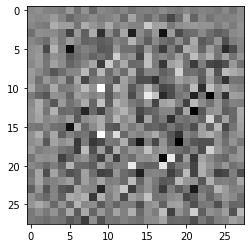

In [14]:
logger.info("Visualization of untrained generator output")
noise = tf.random.normal(shape = (1, FEAT_DIM))
generated_img = generator(noise, training = False)
plt.imshow(tf.reshape(generated_img[0], [28,28,1])[:,:,0], cmap='gray')

In [15]:
logger.debug("Defining separate optimizers for discriminator and generator..")
logger.debug("Using ADAM optimizer for both generator and discriminator!")
generator_optimizer = keras.optimizers.Adam(lr = 0.0001)
discriminator_optimizer = keras.optimizers.Adam(lr = 0.0001)

logger.debug("Using BinaryCrossentropy for loss function")
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

# Storing the mean loss
discriminator_loss = tf.keras.metrics.Mean(name='discriminator_loss')
discriminator_real_loss = tf.keras.metrics.Mean(name='discriminator_real_loss')
discriminator_fake_loss = tf.keras.metrics.Mean(name='discriminator_fake_loss')
generator_loss = tf.keras.metrics.Mean(name='generator_loss')

In [16]:
# Training function for Discriminator
@tf.function
def train_discriminator(real):
    noise = tf.random.normal(shape = (BATCH_SIZE, FEAT_DIM))
    with tf.GradientTape() as tape:
        fake = generator(noise, training = False)
        real_pred = discriminator(real, training = True)
        real_loss = cross_entropy(tf.ones_like(real_pred), real_pred)
        fake_pred = discriminator(fake, training = True)
        fake_loss = cross_entropy(tf.zeros_like(fake_pred), fake_pred)
        total_loss = real_loss + fake_loss
    gradient = tape.gradient(total_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradient, discriminator.trainable_variables))
    
    discriminator_loss(total_loss)
    discriminator_real_loss(real_loss)
    discriminator_fake_loss(fake_loss)
    gc.collect()

In [17]:
# Training function for Generator
@tf.function
def train_generator():
    noise = tf.random.normal(shape = (BATCH_SIZE, FEAT_DIM))
    with tf.GradientTape() as tape:
        fake = generator(noise, training = True)
        fake_pred = discriminator(fake, training = False)
        fake_loss = cross_entropy(tf.ones_like(fake_pred), fake_pred)
    gradient = tape.gradient(fake_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))
    
    generator_loss(fake_loss)
    gc.collect()

In [18]:
train_log_dir = 'logs/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [19]:
logger.debug("Beginning training..")
for epoch in range(1, EPOCHS+1):
    for real in train_ds:
        train_discriminator(real)
        train_generator()
    with train_summary_writer.as_default():
        tf.summary.scalar('Discriminator loss', discriminator_loss.result(), step=epoch)
        tf.summary.scalar('Generator loss', generator_loss.result(), step=epoch)
        tf.summary.scalar("Discriminator real loss", discriminator_real_loss.result(), step=epoch)
        tf.summary.scalar("Discriminator fake loss", discriminator_fake_loss.result(), step=epoch)
    logger.debug("Epoch: %d - Discriminator loss: %f - Generator loss: %f", epoch, discriminator_loss.result(), generator_loss.result())
    discriminator_loss.reset_states()
    discriminator_real_loss.reset_states()
    discriminator_fake_loss.reset_states()
    generator_loss.reset_states()
    if epoch%10 == 0:
        fig, ax = plt.subplots(5, 5, figsize = (15, 15))
        buf = io.BytesIO()
        noise = tf.random.normal(shape = (25, FEAT_DIM))
        generated_images = generator(noise, training = False)
        generated_images = tf.reshape(generated_images, [25, 28, 28, 1])
        for i in range(25):
            _ = ax[i//5, i%5].imshow(generated_images[i][:, :, 0], cmap = "gray")
        plt.savefig(buf, format = "png")
        plt.close(fig)
        image = tf.image.decode_png(buf.getvalue(), channels = 4)
        image = tf.expand_dims(image, 0)
        with train_summary_writer.as_default():
            tf.summary.image("Generated Images", image, step = epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



--- Logging error ---
Traceback (most recent call last):
  File "D:\Anaconda3\envs\DL\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "D:\Anaconda3\envs\DL\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "D:\Anaconda3\envs\DL\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "D:\Anaconda3\envs\DL\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not enough arguments for format string
Call stack:
  File "D:\Anaconda3\envs\DL\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\envs\DL\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\envs\DL\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File

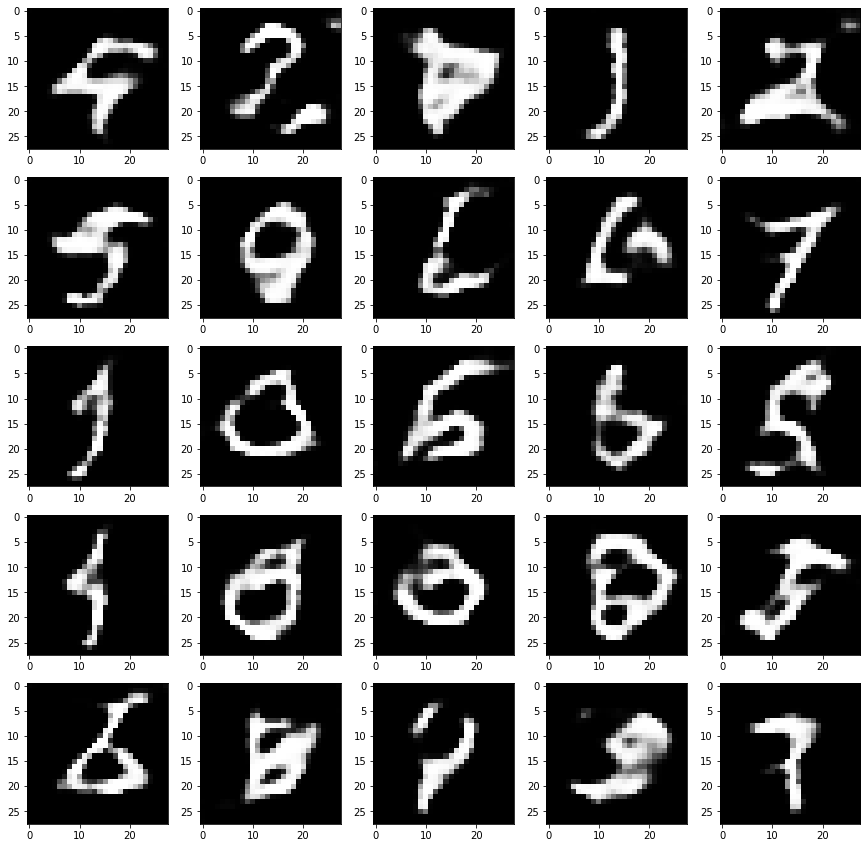

In [20]:
fig, ax = plt.subplots(5, 5, figsize = (15, 15))
noise = tf.random.normal(shape = (25, FEAT_DIM))
generated_images = generator(noise, training = False)
generated_images = tf.reshape(generated_images, [25, 28, 28, 1])
for i in range(25):
    ax[i//5, i%5].imshow(generated_images[i][:, :, 0], cmap = "gray")

In [21]:
logger.debug("Saving models..")
generator.save("models/"+current_time+"/generator.h5")
discriminator.save("models/"+current_time+"/discriminator.h5")

In [23]:
logger.debug("exiting..")
del generator
del discriminator
del X_train